In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Dataset/sentiment-final.csv", encoding="latin-1")

In [ ]:
data.head()

,query,sentiment
0,Absolutely wonderful - silky and sexy and comf...,Positive
1,Love this dress! it's sooo pretty. i happene...,Positive
2,"I love, love, love this jumpsuit. it's fun, fl...",Positive
3,This shirt is very flattering to all due to th...,Positive
4,I aded this in my basket at hte last mintue to...,Positive


In [ ]:
data.shape

(30078, 2)

In [ ]:
one_hot = pd.get_dummies(data['sentiment'])
data.drop(['sentiment'], axis=1, inplace=True)
data = pd.concat([data, one_hot], axis=1)
data.head()

,query,Negative,Neutral,Positive
0,Absolutely wonderful - silky and sexy and comf...,0,0,1
1,Love this dress! it's sooo pretty. i happene...,0,0,1
2,"I love, love, love this jumpsuit. it's fun, fl...",0,0,1
3,This shirt is very flattering to all due to th...,0,0,1
4,I aded this in my basket at hte last mintue to...,0,0,1


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
X = data["query"].values
y = data.drop(["query"], axis=1).values

max_features = 20000
maxlen = 150
vocab_size = 20000

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=150)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(21054, 150) (21054, 3)
(9024, 150) (9024, 3)


In [ ]:
import pickle

# Save the tokenizer to a file using pickle
with open('/content/drive/MyDrive/Dataset/tokenizer-sentiment-analysis.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(y)

[[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [ ]:
embed_dim = 50
num_heads = 2
ff_dim = 50

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping]
)

Epoch 1/10
165/165 [==============================] - 20s 94ms/step - loss: 0.9800 - accuracy: 0.4770 - val_loss: 0.7839 - val_accuracy: 0.6088
Epoch 2/10
165/165 [==============================] - 9s 53ms/step - loss: 0.6358 - accuracy: 0.7148 - val_loss: 0.5583 - val_accuracy: 0.7695
Epoch 3/10
165/165 [==============================] - 6s 34ms/step - loss: 0.4121 - accuracy: 0.8456 - val_loss: 0.4494 - val_accuracy: 0.8438
Epoch 4/10
165/165 [==============================] - 5s 30ms/step - loss: 0.2767 - accuracy: 0.9077 - val_loss: 0.4353 - val_accuracy: 0.8575
Epoch 5/10
165/165 [==============================] - 5s 29ms/step - loss: 0.1963 - accuracy: 0.9370 - val_loss: 0.4645 - val_accuracy: 0.8623
Epoch 6/10
165/165 [==============================] - 4s 26ms/step - loss: 0.1532 - accuracy: 0.9509 - val_loss: 0.4433 - val_accuracy: 0.8824
Epoch 7/10
165/165 [==============================] - 5s 27ms/step - loss: 0.1249 - accuracy: 0.9619 - val_loss: 0.4983 - val_accuracy: 0.871

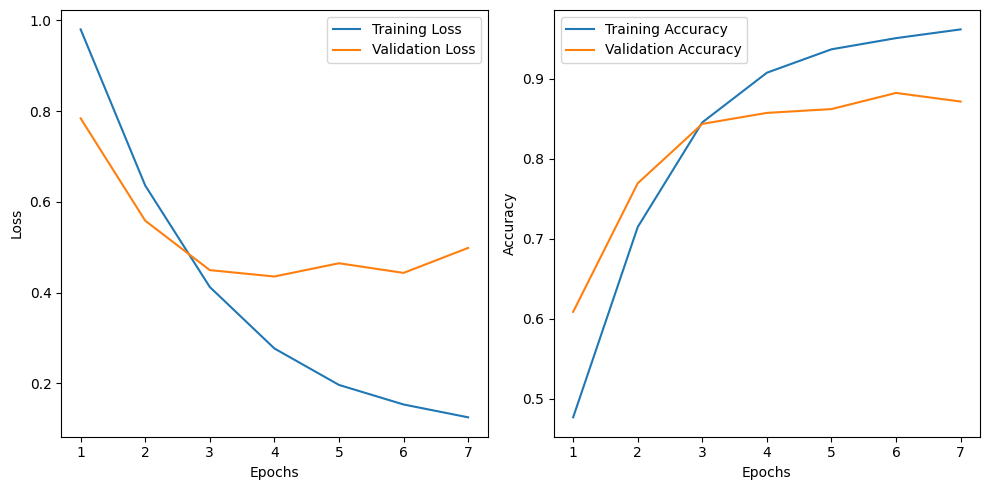

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss and accuracy
epochs = np.arange(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels)
print(report)

282/282 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      3078
           1       0.76      0.88      0.82      2888
           2       0.94      0.82      0.87      3058

    accuracy                           0.86      9024
   macro avg       0.86      0.86      0.86      9024
weighted avg       0.87      0.86      0.86      9024



In [ ]:
model.save("/content/drive/MyDrive/Dataset/SentimentAnalysis.h5")

In [ ]:
text = ["This dress is perfection! so pretty and flattering."]

preprocessed_text = preprocess_sentence(text[0])

text_sequence = tokenizer.texts_to_sequences([preprocessed_text])

text_sequence = pad_sequences(text_sequence, maxlen=maxlen)

sentiment = model.predict(text_sequence, batch_size=1, verbose=2)[0]

print(sentiment)

if (np.argmax(sentiment) == 0):
  print("Negative")
elif (np.argmax(sentiment) == 1):
  print("Neutral")
else:
  print("Positive")

1/1 - 0s - 65ms/epoch - 65ms/step
[0.00317648 0.01382934 0.9829942 ]
positive
